In [2]:
import time
import os

import numpy as np
import cv2
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import psutil

import pyautogui
from pywinauto import Application

In [16]:
certificate_password = os.getenv('CERTIFICATE_PASSWROD', 'wlghksdl78!')
driver_path = os.getenv("DRIVER_PATH", 'C:/dev/Chrome/chromedriver')
download_file_path = os.getenv("DOWNLOAD_FILE_PATH", 'C:/dev/files')
date_from = os.getenv("DATE_FROM", "20180901")
date_to = os.getenv("DATE_TO", "20190309")
account_info_path = os.getenv("ACCOUNT_INFO_PATH", 'bank/계좌내역_통합.xlsx')

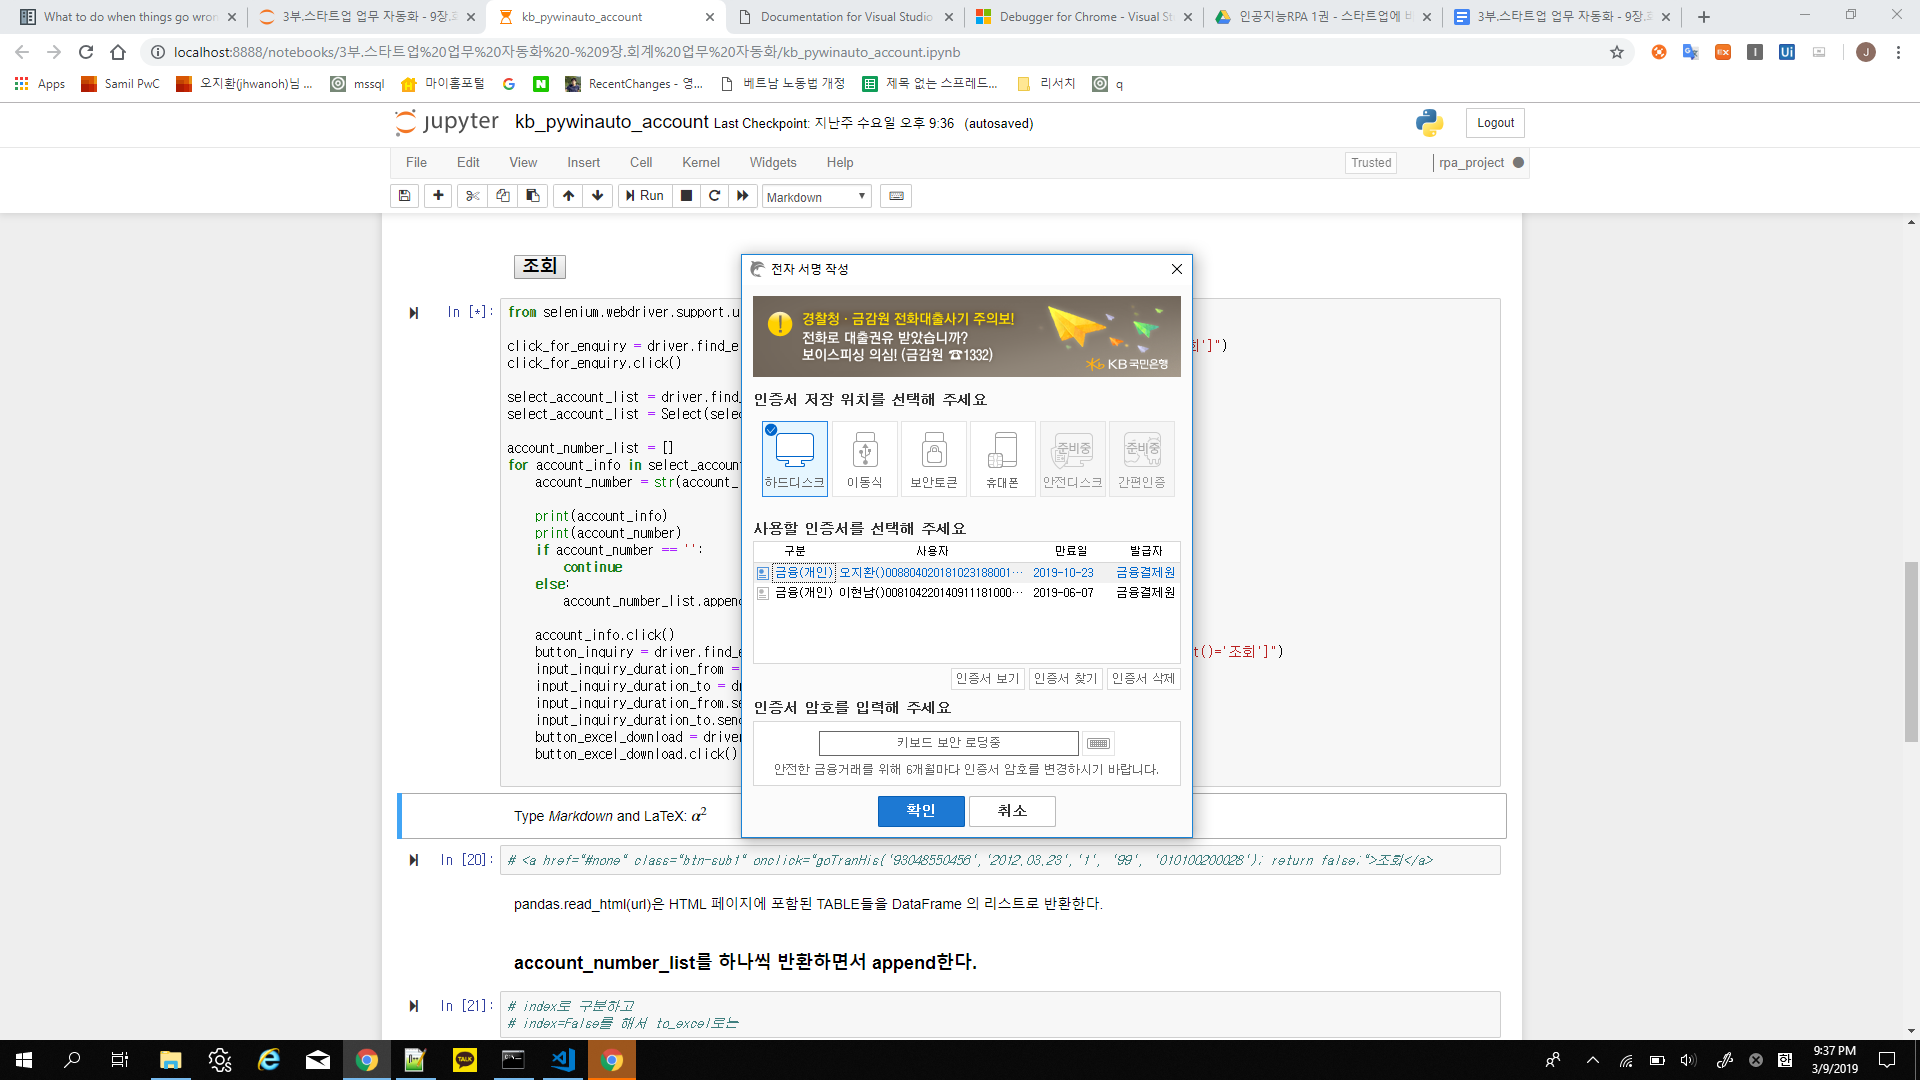

In [23]:
options = Options()
# chrome user agent를 지정해주기
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36")

#     "download.default_directory" : // String which specifies where to download files to by default.
#     "download.prompt_for_download" : // Boolean which specifies whether we should ask the user if we should download // a file (true) or just download it automatically.
#     "download.directory_upgrade" : // Boolean that records if the download directory was changed by an // upgrade a unsafe location to a safe location.
#     "safebrowsing.enabled" : 

options.add_experimental_option('prefs', {
    "download.default_directory": download_file_path,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True,
    "safebrowsing.enabled": True
})

driver = webdriver.Chrome(driver_path, options=options)
driver.implicitly_wait(5)
driver.get('https://obank.kbstar.com/quics?page=C055068&QSL=F#loading')
cookies = driver.get_cookies()

driver.maximize_window()
button_for_login = driver.find_element_by_xpath("//button[@class='btn'][@title='새창']")
button_for_login.click()

# 공인인증서를 위한 sleep 3초 
time.sleep(4)
pyautogui.screenshot('kb/current.png')

### 공인인증서 로그인 (pywinauto)

In [24]:

process_id = 0
for proc in psutil.process_iter():
    if "delfino" in proc.name():
        process_id = proc.pid
        break
        
delfino = Application(backend='uia').connect(process=process_id)
window = delfino.top_window()

cancel_button = window.child_window(title="취소", control_type="Button")
ok_button = window.child_window(title="확인", control_type="Button")
Pane_object = window.Pane3

key_board = window.GroupBox.Pane
Edit = key_board.Pane2.Edit
Edit.select()
pyautogui.typewrite(certificate_password)
time.sleep(2)
ok_button.click()

<uia_controls.ButtonWrapper - '확인', Button, 3713039623702003531>

### 엑셀파일다운로드

### <a href="#none" class="btn-sub1" onclick="goTranHis('93048550456','2012.03.23','1', '99', '010100200028'); return false;">조회</a>

### <select name="계좌번호" id="계좌번호" class="selbox" onclick="" onchange="">
	<option value="">-선택-</option><option value="93048550456" selected="selected">93048550456 : KB 樂 Star통장-저축예금 </option>

</select>

### <button type="button" class="btn-com c2" onclick="uf_GoSubmit();return false">조회</button>

In [25]:
from selenium.webdriver.support.ui import Select

click_for_enquiry = driver.find_element_by_xpath("//a[contains(@onclick, 'goTranHis')][text()='조회']")
click_for_enquiry.click()

select_account_list = driver.find_element_by_xpath("//select[@id='계좌번호']")
select_account_list = Select(select_account_list)

account_number_list = []
for account_info in select_account_list.options:
    account_number = str(account_info.get_attribute('value'))
    
    print(account_info)
    print(account_number)
    if account_number == '':
        continue
    else:
        account_number_list.append(account_number)

    account_info.click()
    button_inquiry = driver.find_element_by_xpath("//button[contains(@onclick, 'uf_GoSubmit')][text()='조회']")
    input_inquiry_duration_from = driver.find_element_by_xpath("//input[@id='SJDATE']")
    input_inquiry_duration_to = driver.find_element_by_xpath("//input[@id='JRDATE']")
    input_inquiry_duration_from.send_keys(date_from)
    input_inquiry_duration_to.send_keys(date_to)
    button_excel_download = driver.find_element_by_xpath("//button[@title='엑셀 저장']")
    button_excel_download.click()
    

<selenium.webdriver.remote.webelement.WebElement (session="140a06ba3e4b58673123db903c3ad0fb", element="0.8799316818927412-3")>

<selenium.webdriver.remote.webelement.WebElement (session="140a06ba3e4b58673123db903c3ad0fb", element="0.8799316818927412-4")>
93048550456


In [20]:
# <a href="#none" class="btn-sub1" onclick="goTranHis('93048550456','2012.03.23','1', '99', '010100200028'); return false;">조회</a>

pandas.read_html(url)은 HTML 페이지에 포함된 TABLE들을 DataFrame 의 리스트로 반환한다.

### account_number_list를 하나씩 반환하면서 append한다.

In [21]:
# index로 구분하고 
# index=False를 해서 to_excel로는 

In [22]:
from openpyxl import load_workbook
import glob
import pandas as pd


for account_number in account_number_list:
    file_path = glob.glob(os.path.join(download_file_path, f"*{account_number}*.xls"))[0]
    new_dataframe = pd.read_html(file_path, header=0)[-1]
    new_dataframe = new_dataframe.set_index([new_dataframe["거래일시"].astype('str').str.strip(), new_dataframe["보낸분/받는분"].astype('str').str.strip()])
    sheet_name = ""
    with pd.ExcelFile(account_info_path) as excel_object:
        for tmp_sheet in excel_object.sheet_names:
            if account_number in tmp_sheet:
                sheet_name = tmp_sheet
    
    
        old_dataframe = excel_object.parse(sheet_name=sheet_name, header=0)
        old_dataframe = old_dataframe.set_index([old_dataframe["거래일시"].astype('str').str.strip(), old_dataframe["보낸분/받는분"].astype('str').str.strip()])
        new_dataframe = new_dataframe.append(old_dataframe)
        new_dataframe = new_dataframe[~new_dataframe.index.duplicated(keep='first')]
        new_dataframe = new_dataframe[~new_dataframe["거래일시"].isnull()]
    
    
    # web에서 다운로드 받은 것을 삭제한다.
    os.remove(file_path)
    
    # 중복으로 있던 93048550456_국민은행 시트를 지움
#     wb = load_workbook(account_info_path)
#     if sheet_name in wb.sheetnames:
#         ws = wb[sheet_name]
#         wb.remove(ws)
#         wb.save(account_info_path)
    
#     wb.close()
    
    with pd.ExcelWriter(account_info_path, engine='openpyxl') as excel_writer:
        wb = load_workbook(account_info_path)
        excel_writer.book = wb
        if sheet_name in wb.sheetnames:
            ws = wb[sheet_name]
            ws.title = "tmp" + sheet_name
            new_dataframe.to_excel(excel_writer, sheet_name=sheet_name, index=False)
            wb.remove(ws)
        else:
            new_dataframe.to_excel(excel_writer, sheet_name=sheet_name, index=False)
            
        
        excel_writer.save()
    
    

In [ ]:
"""
"download 받은 엑셀의 filename의 규칙",
"KB_거래내역조회({계좌번호}_{조회일시})",
"ex ) KB_거래내역조회(93048550456_20190224144012) 이런 식으로 조회됨.",
"excel file 구성내용",
"거래일시 : ",
"적요 : B5",
"보낸분/받는분 : C5",
"송금메모 : D5",
"출금액 : E5",
"입금액 : F5",
"잔액 : G5",
"거래점 : H5",
"구분 : I5",
"""